# Autoencoder
I want to use an autoencoder for dimensionality reduction on the full dataset with 1400+ features. <br>
At the moment, the autoencoder has the following structure. <br>
<br>

![Diagram](AE_diagram.png)
<br>
The input variables are separated into categorical and continuous features. The categorical features are embedded and dropout is added. The continous features are treated with a batchnorm layer. Afterwards, all features are concatenate into a single Tensor. <br>
The encoder is still very basic, consisting of two linear and one ReLu layer, reducing the dimensionality to 128 features. When using the full dataset with over 1400 features, I will probably add another linear layer (plus ReLu) going 512->256->128. <br>
The decoder is the exact inverse of the encoder.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

For now, I'll use the smaller, manually reduced, dataset to make testing faster. When everything is working well, I will run this on the full dataset.

In [3]:
df = pd.read_csv('dataset_reduced.csv')

In [4]:
df['DAYS_BIRTH'] = df['DAYS_BIRTH'].astype('float64')
df['DAYS_ID_PUBLISH'] = df['DAYS_ID_PUBLISH'].astype('float64')
df['SK_ID_CURR'] = df['SK_ID_CURR'].astype('float64')

In [5]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,client_installments_AMT_INSTALMENT_max_mean,client_installments_AMT_PAYMENT_sum_min,client_installments_AMT_INSTALMENT_max_max,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum
0,100002.0,1.0,Cash loans,M,406597.5,24700.5,Secondary / secondary special,Single / not married,0.018801,-9461.0,...,53093.746,219625.700,53093.746,219625.700,175783.73,175783.73,219625.700,219625.690,1008781.200,4.172888e+06
1,100003.0,0.0,Cash loans,F,1293502.5,35698.5,Higher education,Married,0.003541,-16765.0,...,175764.050,80773.380,560835.400,453952.220,1154108.20,1154108.20,1150977.400,1618864.600,4394101.500,1.134881e+07
2,100004.0,0.0,Revolving loans,M,135000.0,6750.0,Secondary / secondary special,Single / not married,0.010032,-19046.0,...,10573.965,21288.465,10573.965,21288.465,16071.75,16071.75,21288.465,21288.465,31721.895,6.386539e+04
3,100006.0,0.0,Cash loans,F,312682.5,29686.5,Secondary / secondary special,Civil marriage,0.008019,-19005.0,...,66116.266,25091.324,691786.900,232499.700,994476.70,994476.70,691786.900,1007153.400,1057860.200,3.719995e+06
4,100007.0,0.0,Cash loans,M,513000.0,21865.5,Secondary / secondary special,Single / not married,0.028663,-19932.0,...,12677.324,18330.390,22678.785,172669.890,483756.38,825845.80,280199.700,806127.940,836703.400,1.139621e+07


In [6]:
for column in df.columns:
    if df[column].dtype != 'float64':
        df[column] = df[column].astype('category')

To determine the size of categorical feature embeddings, I use a rule of thumb developed by the FastAI team. <br>

In [7]:
def emb_sz_rule(n_cat): return round(1.6 * n_cat**0.56) ## rule of thumb

def def_emb_sz(df):
    sz_dict = {}
    n_cat = df.nunique().values
    sz = [(x, emb_sz_rule(x)) for x in n_cat]

    return sz

In [8]:
## a helper function that takes in the base dataset, does some preprocessing and returns the dataset split into train/test and categorical/continuous variables
def load_data(df, valid_size=0.2):
    x = df.drop(columns=['SK_ID_CURR', 'TARGET', 'test'])
    x = x.replace([np.inf, -np.inf], np.nan) ## only needed for the reduced dataset, remove this when ready

    ## train test split
    ix = int(len(df)*valid_size)
    x = x.sample(frac=1).reset_index() ## shuffle
    x['valid'] = False
    x.loc[0:ix, 'valid'] = True

    
    ## handle categorical variables
    x_cat = x.select_dtypes(['category', 'bool'])
    x_cat = x_cat.apply(preprocessing.LabelEncoder().fit_transform)
    emb_sz = def_emb_sz(x_cat)[:-1] ## the last element is the "valid" variable, drop it
    x_cat_train, x_cat_test = x_cat[x_cat['valid'] == False].drop(columns='valid'), x_cat[x_cat['valid'] == True].drop(columns='valid')
    x_cat_train, x_cat_test = x_cat_train.values.reshape(-1, x_cat_train.shape[1]).astype('int64'), x_cat_test.values.reshape(-1, x_cat_test.shape[1]).astype('int64')
    
    ## handle continuous variables
    x_cont = x.select_dtypes(['float64', 'bool'])
    x_cont = x_cont.fillna(0)
    x_cont_train, x_cont_test = x_cont[x_cont['valid'] == False].drop(columns='valid'), x_cont[x_cont['valid'] == True].drop(columns='valid')
    x_cont_train, x_cont_test = x_cont_train.values.reshape(-1, x_cont_train.shape[1]).astype('float32'), x_cont_test.values.reshape(-1, x_cont_test.shape[1]).astype('float32')
    
    standardizer = preprocessing.StandardScaler()
    x_cont_train = standardizer.fit_transform(x_cont_train) ## only fit on train set
    x_cont_test = standardizer.transform(x_cont_test)
    

    return x_cat_train, x_cat_test, x_cont_train, x_cont_test, emb_sz

In [9]:
## custom dataset class
class AEDataset(Dataset):
    def __init__(self, x_cat, x_cont, emb_sz):
        self.x_cat, self.x_cont,self.emb_sz = x_cat, x_cont, emb_sz
        self.n_cont = self.x_cont.shape[1]
        self.n_cat = self.x_cat.shape[1]
        self.len = self.n_cont + self.n_cat

    def __getitem__(self,index):      
        return self.x_cont[index], self.x_cat[index]
    def __len__(self):
        return self.len

In [10]:
def get_datasets(df):
    x_cat_train, x_cat_test, x_cont_train, x_cont_test, emb_sz = load_data(df)
    
    train_dataset = AEDataset(x_cat_train, x_cont_train, emb_sz)
    test_dataset = AEDataset(x_cat_test, x_cont_test, emb_sz)

    return train_dataset, test_dataset

In [11]:
train_dataset, test_dataset = get_datasets(df)

train_dataloader = DataLoader(dataset=train_dataset,batch_size=1024)
test_dataloader = DataLoader(dataset=test_dataset,batch_size=1024)

In [12]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, emb_szs, n_cont, dropout=0.2):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in emb_szs])  
        n_emb = sum([size for categories,size in emb_szs]) #sum embedding sizes
        n_cat = sum([categories for categories,size in emb_szs]) ## sum category labels
        self.n_emb, self.n_cont, self.n_cat = n_emb, n_cont, n_cat
        self.n_input = n_emb + n_cont
        
        self.bn1 = nn.BatchNorm1d(self.n_cont)
        self.emb_dropout = nn.Dropout(dropout)
        self.bn_cont = nn.BatchNorm1d(self.n_cont)

         
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.n_input, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
        )
          

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, self.n_input),
        )
        
    
    ## function to turn embeddings into label probabilities
    def decode_embeddings(self, values, proba=False):
        softmax = torch.nn.Softmax(dim=0)
        
        start = 0

        out = torch.empty((290,0), requires_grad=True).long().to(device)

        ### loop through each embedding
        ## TODO: there has to be a better way to do this than two loops
        for emb in self.embeddings:
            
            stop = start + emb.weight.data.shape[1]
            
            pred = torch.empty((0,emb.weight.data.shape[0])).to(device) ## create empty tensor of size (0,n) where n is the number of feature labels
                
            ## loop through each item in the batch   
            for i in range(290):
                
                ## get the euclidian distance between input values and feature embeddings
                distance = ((emb.weight.data - values[i,start:stop])**2).sum(axis=1)
 
                ## softmax assigns the highest probability to the highest input value
                ## I take the negative to give assign the highest probability to the smallest distance
                p = softmax(-distance).unsqueeze(0)
                    
                pred = torch.cat([pred,p])
                    
            out = torch.cat([out,pred],axis=1)
            start = stop  
        
        return out
    
    

    def forward(self, x_cont, x_cat, encode=False):
        x_cat = x_cat.to(device)
        x_cont = x_cont.to(device)

        ## embedd categorical features and add dropout
        x = [emb(x_cat[:,i]) for i, emb in enumerate(self.embeddings)]   
        x = torch.cat(x, 1)
        x = self.emb_dropout(x)

        ## batch norm on continuous features
        x2 = self.bn_cont(x_cont)
        
        ## concat cat and cont features
        x = torch.cat([x, x2], 1) 
        
        ## encode features
        x = self.encoder(x)
        
        ## if I only want to encode features, stop here
        if encode:
            return x
        
        
        ## decode encoded features
        x = self.decoder(x)
        
        ## get continuous features
        x_cont_out = x[:,self.n_emb:]
        
        ## get categorical features and reverse embedding
        x_cat_out = x[:,0:self.n_emb]
        x_cat_out = self.decode_embeddings(x_cat_out)
        
        return x_cont_out, x_cat_out

In [13]:
len_x = train_dataset.len
len_cont = train_dataset.n_cont
emb_sz = train_dataset.emb_sz
model = AutoEncoder(emb_sz, len_cont).to(device)

In [14]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction='sum')
        self.ce_loss = nn.CrossEntropyLoss(reduction='sum')
    
    def forward(self, x_cont_ae, x_cat_ae, x_cont, x_cat):

        ## loss for the continuous features is simply MSE
        cont_loss = self.mse_loss(x_cont_ae, x_cont)
        
        ## the input categorical features are label encoded, but one-hot encoding is needed to calculate cross entropy loss
        one_hot = torch.empty((290,0), requires_grad=True).long().to(device)
        
        for i in range(x_cat.shape[1]):
            n_classes = train_dataset.x_cat[:,i].max() + 1 ## not every label is present in a batch, so I have to supply the amount of feature labels   
            out = nn.functional.one_hot(x_cat[:,i], num_classes=n_classes).to(device)
            one_hot = torch.cat([one_hot,out], axis=1)
        
        one_hot = one_hot.float()
     
        ## now I can easily calculate cross entropy loss
        cat_loss = self.ce_loss(x_cat_ae, one_hot)
        
        ## take the sum as the final output
        loss = cont_loss + cat_loss
        

        return loss

In [15]:
loss_function = customLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-2,
                             weight_decay = 1e-8)

In [16]:
epochs = 100
val_losses = []
train_losses = []
patience = 10

In [17]:
for e in range(epochs):
    
    ## train
    train_loss = 0.0
    model.train()
    for batch_idx, data in enumerate(train_dataloader):
        x_cont, x_cat = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        x_cont_ae, x_cat_ae = model(x_cont, x_cat)
        
        loss = loss_function(x_cont_ae, x_cat_ae, x_cont, x_cat)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
     
    
    ## validate
    valid_loss = 0.0
    model.eval()
    for batch_idx, data in enumerate(test_dataloader):
        x_cont, x_cat = data[0].to(device), data[1].to(device)
         
        x_cont_ae, x_cat_ae = model(x_cont, x_cat)
        
        loss = loss_function(x_cont_ae, x_cat_ae, x_cont, x_cat)
        
        valid_loss += loss.item()
        
    
    train_losses.append(train_loss / len(train_dataloader.dataset))
    val_losses.append(valid_loss / len(test_dataloader.dataset))
 
    print('Epoch {}. Train loss: {:.2f}. Valid loss: {:.2f}.'.format(e, train_losses[-1], val_losses[-1]))
    
    if (e > patience) & (min(val_losses[-patience:]) != min(val_losses)):
        print('No improvement for {} epochs. Ending training.'.format(patience))
        break

Epoch 0. Train loss: 403.16. Valid loss: 349.51.
Epoch 1. Train loss: 381.82. Valid loss: 347.52.
Epoch 2. Train loss: 365.78. Valid loss: 336.82.
Epoch 3. Train loss: 358.09. Valid loss: 330.17.
Epoch 4. Train loss: 352.85. Valid loss: 312.84.
Epoch 5. Train loss: 321.51. Valid loss: 312.72.
Epoch 6. Train loss: 312.55. Valid loss: 293.91.
Epoch 7. Train loss: 279.21. Valid loss: 288.97.
Epoch 8. Train loss: 256.86. Valid loss: 280.50.
Epoch 9. Train loss: 244.51. Valid loss: 277.63.
Epoch 10. Train loss: 233.97. Valid loss: 271.16.
Epoch 11. Train loss: 226.87. Valid loss: 264.57.
Epoch 12. Train loss: 218.93. Valid loss: 261.35.
Epoch 13. Train loss: 212.63. Valid loss: 258.49.
Epoch 14. Train loss: 204.49. Valid loss: 257.75.
Epoch 15. Train loss: 199.96. Valid loss: 255.90.
Epoch 16. Train loss: 196.84. Valid loss: 252.30.
Epoch 17. Train loss: 191.58. Valid loss: 249.07.
Epoch 18. Train loss: 185.23. Valid loss: 246.16.
Epoch 19. Train loss: 179.36. Valid loss: 244.16.
Epoch 20. 

## Preliminary Result
The training loss is really good, the model is able to recreate the input variables very well. However, the validation loss is converging very fast. I could probably improve this by adding more regularization. <br>
I'm not quite sure if I should even consider validation loss when my only objective is to reduce the dimensionality of a known dataset. I'll have to do some research on this.

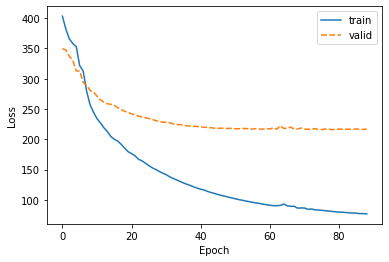

In [18]:
plot_df = pd.DataFrame({'train': train_losses, 'valid': val_losses})
ax = sns.lineplot(data=plot_df)
ax.set(xlabel='Epoch', ylabel='Loss')
plt.show()